In [1]:
import sys

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from tqdm import tqdm
from itertools import combinations
from tqdm import tqdm

sys.path.append("../src/")

import xgi
from reducibility_hg import *

from statannotations.Annotator import Annotator

sb.set_theme(style="ticks", context="paper")

In [2]:
results_dir = "../results/"
out_dir = f"{results_dir}synthetic/"

In [3]:
def sigma(d):
    """
    Return d*(d+1)/2, the sum of the first d integers"""
    return d * (d + 1) / 2

## generate complete hypergraph

In [275]:
N = 30
rescale = False
d_max = 4

H0 = xgi.complete_hypergraph(N=N, max_order=d_max)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

In [276]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)

inverse_rescaling_factors = [sigma(d_max) / sigma(d) for d in orders]
Ds_H, lZs_H = optimization(
    H0, tau_c, rescaling_factors=inverse_rescaling_factors, rescale_per_node=rescale
)

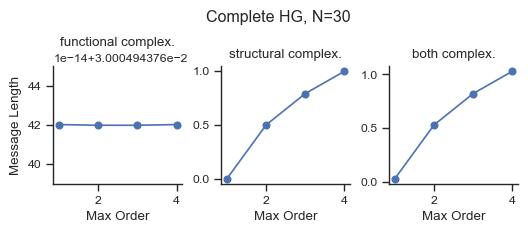

In [277]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))

message_length = Ds_H + lZs_H
ax.plot(orders, message_length, "o-")

penal_structure = np.log(orders) / np.log(d_max)
ax2.plot(orders, Ds_H + penal_structure, "o-")

ax3.plot(orders, message_length + penal_structure, "o-")

ax.set_ylabel("Message Length")
ax.set_xlabel("Max Order")
ax.set_title("functional complex.")

fig.suptitle(f"Complete HG, N={N}")
ax2.set_title("structural complex.")
ax2.set_xlabel("Max Order")

ax3.set_title("both complex.")
ax3.set_xlabel("Max Order")

plt.subplots_adjust(top=0.7, wspace=0.3)

sb.despine()

fig_name = f"message_length_all_to_all_rescaled_tauc_N_{N}"

# plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [278]:
np.diff(message_length)

array([-3.60822483e-16,  0.00000000e+00,  3.60822483e-16])

## generate full triangular lattice

In [4]:
def triangular_lattice_flag(n_rows, p2, periodic=False):
    """
    Generates a flag complex from a triangular lattice graph.

    Parameters
    ----------
    n_rows : int
        Number of rows in the lattice.
    p2 : float
        Probability of adding a 2-simplex to the clique complex.
    periodic : bool, optional
        Whether the lattice should have periodic boundary conditions. Default is False.

    Returns
    -------
    S_lattice : xgi Simplicial Complex

    pos : dict
        Node positions keyed by node ID.
    """

    # number of rows
    m = n_rows - 1
    # number of columns
    columns = n_rows + 1
    n = 2 * columns - 1

    if not periodic:
        n = n - 1
        m = m - 1

    # generate lattice
    G_lattice = nx.triangular_lattice_graph(
        m, n, periodic=periodic, with_positions=True
    )
    G_lattice = nx.convert_node_labels_to_integers(G_lattice)
    pos = nx.get_node_attributes(G_lattice, "pos")

    # generate random clique complex (fill in triangles)
    S_lattice = xgi.flag_complex_d2(G_lattice, p2=p2)
    return S_lattice, pos

In [5]:
n_rows = 16
rescale = False
d_max = 2
p_2 = 1

H0, _ = triangular_lattice_flag(n_rows, p2=p_2, periodic=True)

orders = np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

N = H0.num_nodes

In [6]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)

inverse_rescaling_factors = [1 / sigma(d) for d in orders]
Ds_H, lZs_H = optimization(
    H0,
    tau_c * sigma(d_max),
    rescaling_factors=inverse_rescaling_factors,
    rescale_per_node=rescale,
)

0.6687565124009927
0.22291883746699753

tau: 0.6687565124009927
factors: [1.0, 0.3333333333333333]
tau*factors: [0.66875651 0.22291884]



In [7]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)

inverse_rescaling_factors = [sigma(d_max) / sigma(d) for d in orders]
Ds_H, lZs_H = optimization(
    H0, tau_c, rescaling_factors=inverse_rescaling_factors, rescale_per_node=rescale
)

0.6687565124009927
0.22291883746699753

tau: 0.22291883746699753
factors: [3.0, 1.0]
tau*factors: [0.66875651 0.22291884]



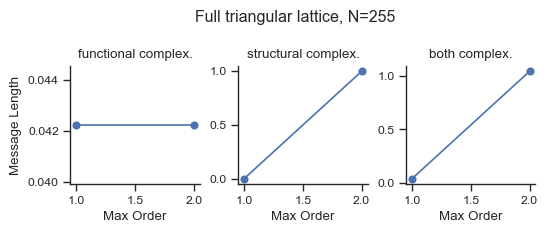

In [282]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))

message_length = Ds_H + lZs_H
ax.plot(orders, message_length, "o-")

penal_structure = np.log(orders) / np.log(d_max)
ax2.plot(orders, Ds_H + penal_structure, "o-")

ax3.plot(orders, message_length + penal_structure, "o-")

ax.set_ylabel("Message Length")
ax.set_xlabel("Max Order")
ax.set_title("functional complex.")

fig.suptitle(f"Full triangular lattice, N={N}")
ax2.set_title("structural complex.")
ax2.set_xlabel("Max Order")

ax3.set_title("both complex.")
ax3.set_xlabel("Max Order")

plt.subplots_adjust(top=0.7, wspace=0.3)

sb.despine()

fig_name = f"message_length_full_triangular_lattice_rescaled_tauc_N_{N}"

# plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [283]:
np.diff(message_length)

array([0.])

## try dataset

In [4]:
data_names = [
    "email-enron",
    "email-eu",
    "hospital-lyon",
    "contact-high-school",
    "contact-primary-school",
    "tags-ask-ubuntu",
    "congress-bills",
    # "disgenenet",
    # "diseasome",
    # "ndc-substances",
    # "coauth-mag-geology",
    # "coauth-mag-history",
]

HGs = {}
for name in tqdm(data_names):
    HGs[name] = xgi.load_xgi_data(name, max_order=None, cache=True)

100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.07s/it]


In [31]:
i = 4  # choose dataset here
name = data_names[i]
print(name)
H0 = HGs[name]
print(H0)
print("max order:", xgi.max_edge_order(H0))
H0.cleanup(isolates=True)
print(H0)

orders = range(1, 7)  # np.array(xgi.unique_edge_sizes(H0)) - 1 + 2
weights = np.ones(len(orders))
N = H0.num_nodes

rescale = False

contact-primary-school
Hypergraph named contact-primary-school with 242 nodes and 12704 hyperedges
max order: 4
Hypergraph named contact-primary-school with 242 nodes and 12704 hyperedges


In [32]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)

inverse_rescaling_factors = [sigma(max(orders)) / sigma(d) for d in orders]
Ds_H, lZs_H = optimization(
    H0, tau_c, rescaling_factors=inverse_rescaling_factors, rescale_per_node=rescale
)

logm result may be inaccurate, approximate err = 3.194697898799808e-13
logm result may be inaccurate, approximate err = 3.0760881030482427e-13
logm result may be inaccurate, approximate err = 3.194697898799808e-13
logm result may be inaccurate, approximate err = 3.139739562940502e-13
logm result may be inaccurate, approximate err = 3.194697898799808e-13
logm result may be inaccurate, approximate err = 3.023298666683338e-13
logm result may be inaccurate, approximate err = 3.194697898799808e-13
logm result may be inaccurate, approximate err = 4.064268783196799e-13


In [37]:
Ds_H

array([0.00742297, 0.00724578, 0.00779552, 0.00713596])

ValueError: x and y must have same first dimension, but have shapes (6,) and (4,)

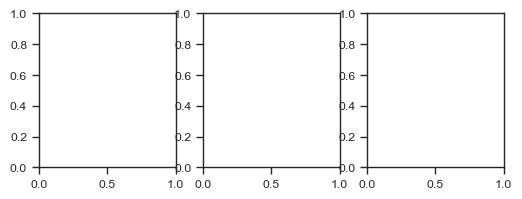

In [33]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))

message_length = Ds_H + lZs_H
ax.plot(orders, message_length, "o-")

penal_structure = np.log(orders) / np.log(max(orders))
ax2.plot(orders, Ds_H + penal_structure, "o-")

ax3.plot(orders, message_length + penal_structure, "o-")

ax.set_ylabel("Message Length")
ax.set_xlabel("Max Order")
ax.set_title("functional complex.")

fig.suptitle(f"{name}, N={N}")
ax2.set_title("structural complex.")
ax2.set_xlabel("Max Order")

ax3.set_title("both complex.")
ax3.set_xlabel("Max Order")

plt.subplots_adjust(top=0.7, wspace=0.3)

sb.despine()

fig_name = f"message_length_{name}_rescaled_tauc"

# plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

In [96]:
np.log(4)

1.3862943611198906

## single orde present

In [137]:
N = 100
d = 2

H0 = xgi.random_hypergraph(N, ps=[1 / N**d], order=d)

In [144]:
orders = [1, 2, 3, 4]  # np.array(xgi.unique_edge_sizes(H0)) - 1
weights = np.ones(len(orders))

N = H0.num_nodes
print(H0)

Unnamed Hypergraph with 100 nodes and 19 hyperedges


In [146]:
tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)

inverse_rescaling_factors = [1 / sigma(d) for d in orders]
Ds_H, lZs_H = optimization(
    H0, tau_c, rescaling_factors=inverse_rescaling_factors, rescale_per_node=rescale
)

/Users/maxime/Dropbox (ISI Foundation)/WORK/SCIENCE/xgi/xgi/linalg/laplacian_matrix.py:173: UserWarning: No edges of order 1. Contribution of that order is zero. Its weight is effectively zero.
  warn(
/Users/maxime/Dropbox (ISI Foundation)/WORK/SCIENCE/xgi/xgi/linalg/laplacian_matrix.py:173: UserWarning: No edges of order 3. Contribution of that order is zero. Its weight is effectively zero.
  warn(
/Users/maxime/Dropbox (ISI Foundation)/WORK/SCIENCE/xgi/xgi/linalg/laplacian_matrix.py:173: UserWarning: No edges of order 4. Contribution of that order is zero. Its weight is effectively zero.
  warn(


ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

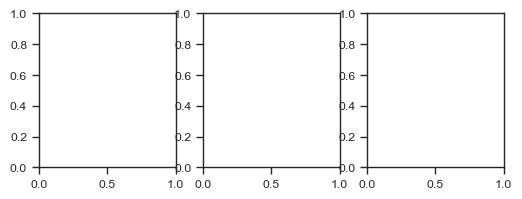

In [147]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 2))

message_length = Ds_H + lZs_H
ax.plot(orders, message_length, "o-")

penal_structure = np.log(orders) / np.log(d_max)
ax2.plot(orders, Ds_H + penal_structure, "o-")

ax3.plot(orders, message_length + penal_structure, "o-")

ax.set_ylabel("Message Length")
ax.set_xlabel("Max Order")
ax.set_title("functional complex.")

fig.suptitle(f"Complete HG, N={N}")
ax2.set_title("structural complex.")
ax2.set_xlabel("Max Order")

ax3.set_title("both complex.")
ax3.set_xlabel("Max Order")

plt.subplots_adjust(top=0.7, wspace=0.3)

sb.despine()

fig_name = f"message_length_full_triangular_lattice_rescaled_tauc_N_{N}"

# plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")

## random hypergraph

In [271]:
N = 100
ps = np.array([1 / N, 1 / N**2, 1 / N**3, 1 / N**4])  # wiring probas
density_scales = [5]

n_rep = 100

rescale = False

Hs = dict()
for density in density_scales:
    Hs_i = []
    for i in tqdm(range(n_rep)):
        print(density * ps)
        H = xgi.random_hypergraph(N, density * ps)
        print(H)
        Hs_i.append(H)
    Hs[density] = Hs_i

orders = np.array(xgi.unique_edge_sizes(Hs[density_scales[0]][0])) - 1
weights = np.ones(len(orders))

  0%|                                                   | 0/100 [00:00<?, ?it/s]

[5.e-02 5.e-04 5.e-06 5.e-08]


  1%|▍                                          | 1/100 [00:03<05:11,  3.14s/it]

Unnamed Hypergraph with 100 nodes and 357 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  2%|▊                                          | 2/100 [00:06<05:03,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 358 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  3%|█▎                                         | 3/100 [00:09<04:58,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 351 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  4%|█▋                                         | 4/100 [00:12<04:53,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 347 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  5%|██▏                                        | 5/100 [00:15<04:50,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 367 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  6%|██▌                                        | 6/100 [00:18<04:48,  3.07s/it]

Unnamed Hypergraph with 100 nodes and 335 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  7%|███                                        | 7/100 [00:21<04:44,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 345 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  8%|███▍                                       | 8/100 [00:24<04:41,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 336 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


  9%|███▊                                       | 9/100 [00:27<04:37,  3.05s/it]

Unnamed Hypergraph with 100 nodes and 361 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 10%|████▏                                     | 10/100 [00:30<04:34,  3.05s/it]

Unnamed Hypergraph with 100 nodes and 385 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 11%|████▌                                     | 11/100 [00:33<04:30,  3.04s/it]

Unnamed Hypergraph with 100 nodes and 350 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 12%|█████                                     | 12/100 [00:36<04:28,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 351 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 13%|█████▍                                    | 13/100 [00:39<04:25,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 333 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 14%|█████▉                                    | 14/100 [00:42<04:22,  3.06s/it]

Unnamed Hypergraph with 100 nodes and 351 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 15%|██████▎                                   | 15/100 [00:45<04:19,  3.05s/it]

Unnamed Hypergraph with 100 nodes and 349 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 16%|██████▋                                   | 16/100 [00:48<04:15,  3.04s/it]

Unnamed Hypergraph with 100 nodes and 371 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 17%|███████▏                                  | 17/100 [00:51<04:12,  3.04s/it]

Unnamed Hypergraph with 100 nodes and 369 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 18%|███████▌                                  | 18/100 [00:54<04:08,  3.03s/it]

Unnamed Hypergraph with 100 nodes and 346 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 19%|███████▉                                  | 19/100 [00:57<04:05,  3.03s/it]

Unnamed Hypergraph with 100 nodes and 357 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 20%|████████▍                                 | 20/100 [01:01<04:02,  3.03s/it]

Unnamed Hypergraph with 100 nodes and 379 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 21%|████████▊                                 | 21/100 [01:04<03:58,  3.03s/it]

Unnamed Hypergraph with 100 nodes and 368 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 22%|█████████▏                                | 22/100 [01:07<03:55,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 327 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 23%|█████████▋                                | 23/100 [01:10<03:52,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 362 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 24%|██████████                                | 24/100 [01:13<03:49,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 352 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 25%|██████████▌                               | 25/100 [01:16<03:47,  3.03s/it]

Unnamed Hypergraph with 100 nodes and 346 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 26%|██████████▉                               | 26/100 [01:19<03:43,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 341 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 27%|███████████▎                              | 27/100 [01:22<03:40,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 347 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 28%|███████████▊                              | 28/100 [01:25<03:37,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 355 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 29%|████████████▏                             | 29/100 [01:28<03:34,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 341 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 30%|████████████▌                             | 30/100 [01:31<03:31,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 318 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 31%|█████████████                             | 31/100 [01:34<03:28,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 327 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 32%|█████████████▍                            | 32/100 [01:37<03:24,  3.01s/it]

Unnamed Hypergraph with 100 nodes and 344 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 33%|█████████████▊                            | 33/100 [01:40<03:21,  3.01s/it]

Unnamed Hypergraph with 100 nodes and 392 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 34%|██████████████▎                           | 34/100 [01:43<03:19,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 379 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 35%|██████████████▋                           | 35/100 [01:46<03:16,  3.02s/it]

Unnamed Hypergraph with 100 nodes and 330 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 36%|███████████████                           | 36/100 [01:49<03:14,  3.03s/it]

Unnamed Hypergraph with 100 nodes and 349 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 37%|███████████████▌                          | 37/100 [01:52<03:15,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 328 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 38%|███████████████▉                          | 38/100 [01:55<03:12,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 349 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 39%|████████████████▍                         | 39/100 [01:58<03:09,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 353 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 40%|████████████████▊                         | 40/100 [02:01<03:04,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 357 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 41%|█████████████████▏                        | 41/100 [02:04<03:01,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 315 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 42%|█████████████████▋                        | 42/100 [02:08<02:59,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 384 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 43%|██████████████████                        | 43/100 [02:11<02:55,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 333 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 44%|██████████████████▍                       | 44/100 [02:14<02:52,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 336 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 45%|██████████████████▉                       | 45/100 [02:17<02:49,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 337 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 46%|███████████████████▎                      | 46/100 [02:20<02:47,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 333 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 47%|███████████████████▋                      | 47/100 [02:23<02:44,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 363 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 48%|████████████████████▏                     | 48/100 [02:26<02:41,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 329 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 49%|████████████████████▌                     | 49/100 [02:29<02:37,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 339 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 50%|█████████████████████                     | 50/100 [02:32<02:35,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 319 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 51%|█████████████████████▍                    | 51/100 [02:36<02:32,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 336 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 52%|█████████████████████▊                    | 52/100 [02:39<02:29,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 341 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 53%|██████████████████████▎                   | 53/100 [02:42<02:25,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 355 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 54%|██████████████████████▋                   | 54/100 [02:45<02:23,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 358 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 55%|███████████████████████                   | 55/100 [02:48<02:20,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 334 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 56%|███████████████████████▌                  | 56/100 [02:51<02:16,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 337 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 57%|███████████████████████▉                  | 57/100 [02:54<02:13,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 329 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 58%|████████████████████████▎                 | 58/100 [02:57<02:10,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 360 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 59%|████████████████████████▊                 | 59/100 [03:00<02:07,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 343 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 60%|█████████████████████████▏                | 60/100 [03:03<02:04,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 349 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 61%|█████████████████████████▌                | 61/100 [03:07<02:00,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 329 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 62%|██████████████████████████                | 62/100 [03:10<01:58,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 358 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 63%|██████████████████████████▍               | 63/100 [03:13<01:55,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 359 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 64%|██████████████████████████▉               | 64/100 [03:16<01:51,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 363 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 65%|███████████████████████████▎              | 65/100 [03:19<01:48,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 364 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 66%|███████████████████████████▋              | 66/100 [03:22<01:45,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 346 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 67%|████████████████████████████▏             | 67/100 [03:25<01:42,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 344 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 68%|████████████████████████████▌             | 68/100 [03:28<01:39,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 345 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 69%|████████████████████████████▉             | 69/100 [03:31<01:35,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 382 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 70%|█████████████████████████████▍            | 70/100 [03:34<01:32,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 352 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 71%|█████████████████████████████▊            | 71/100 [03:37<01:29,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 341 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 72%|██████████████████████████████▏           | 72/100 [03:41<01:26,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 347 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 73%|██████████████████████████████▋           | 73/100 [03:44<01:23,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 344 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 74%|███████████████████████████████           | 74/100 [03:47<01:21,  3.13s/it]

Unnamed Hypergraph with 100 nodes and 336 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 75%|███████████████████████████████▌          | 75/100 [03:50<01:18,  3.13s/it]

Unnamed Hypergraph with 100 nodes and 344 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 76%|███████████████████████████████▉          | 76/100 [03:53<01:14,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 356 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 77%|████████████████████████████████▎         | 77/100 [03:56<01:11,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 357 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 78%|████████████████████████████████▊         | 78/100 [03:59<01:08,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 338 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 79%|█████████████████████████████████▏        | 79/100 [04:02<01:05,  3.13s/it]

Unnamed Hypergraph with 100 nodes and 357 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 80%|█████████████████████████████████▌        | 80/100 [04:06<01:02,  3.13s/it]

Unnamed Hypergraph with 100 nodes and 363 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 81%|██████████████████████████████████        | 81/100 [04:09<00:59,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 368 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 82%|██████████████████████████████████▍       | 82/100 [04:12<00:56,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 357 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 83%|██████████████████████████████████▊       | 83/100 [04:15<00:52,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 349 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 84%|███████████████████████████████████▎      | 84/100 [04:18<00:49,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 342 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 85%|███████████████████████████████████▋      | 85/100 [04:21<00:46,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 369 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 86%|████████████████████████████████████      | 86/100 [04:24<00:43,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 402 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 87%|████████████████████████████████████▌     | 87/100 [04:27<00:40,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 354 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 88%|████████████████████████████████████▉     | 88/100 [04:31<00:37,  3.12s/it]

Unnamed Hypergraph with 100 nodes and 345 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 89%|█████████████████████████████████████▍    | 89/100 [04:34<00:34,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 374 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 90%|█████████████████████████████████████▊    | 90/100 [04:37<00:31,  3.11s/it]

Unnamed Hypergraph with 100 nodes and 352 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 91%|██████████████████████████████████████▏   | 91/100 [04:40<00:27,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 365 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 92%|██████████████████████████████████████▋   | 92/100 [04:43<00:24,  3.10s/it]

Unnamed Hypergraph with 100 nodes and 363 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 93%|███████████████████████████████████████   | 93/100 [04:46<00:21,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 349 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 94%|███████████████████████████████████████▍  | 94/100 [04:49<00:18,  3.09s/it]

Unnamed Hypergraph with 100 nodes and 371 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 95%|███████████████████████████████████████▉  | 95/100 [04:52<00:15,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 351 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 96%|████████████████████████████████████████▎ | 96/100 [04:55<00:12,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 361 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 97%|████████████████████████████████████████▋ | 97/100 [04:58<00:09,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 382 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 98%|█████████████████████████████████████████▏| 98/100 [05:01<00:06,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 350 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


 99%|█████████████████████████████████████████▌| 99/100 [05:04<00:03,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 351 hyperedges
[5.e-02 5.e-04 5.e-06 5.e-08]


100%|█████████████████████████████████████████| 100/100 [05:08<00:00,  3.08s/it]

Unnamed Hypergraph with 100 nodes and 361 hyperedges


In [241]:
info_losses = dict()
complexities = dict()
orders_arr = dict()
message_lengths = dict()

for density, Hs_i in Hs.items():

    info_losses_i = []
    complexities_i = []
    orders_arr_i = []
    message_lengths_i = []

    for H0 in tqdm(Hs_i):

        orders = np.array(xgi.unique_edge_sizes(H0)) - 1
        weights = np.ones(len(orders))
        # tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)
        # Ds_H, lZs_H, orders = compute_information(H0, tau_c, rescale_per_node=rescale)
        tau_c = find_charact_tau(H0, orders, weights, rescale_per_node=rescale)
        inverse_rescaling_factors = [sigma(max(orders)) / sigma(d) for d in orders]
        Ds_H, lZs_H = optimization(
            H0,
            tau_c,
            rescaling_factors=inverse_rescaling_factors,
            rescale_per_node=rescale,
        )

        info_losses_i.append(Ds_H)
        complexities_i.append(lZs_H)
        orders_arr_i.append(orders)
        message_lengths_i.append(Ds_H + lZs_H)

    info_losses[density] = info_losses_i
    complexities[density] = complexities_i
    orders_arr[density] = orders_arr_i
    message_lengths[density] = message_lengths_i

labels = [f"{i}" for i in density_scales]

100%|█████████████████████████████████████████| 100/100 [05:50<00:00,  3.50s/it]


In [242]:
for i, s in enumerate(density_scales):
    message_lengths[s] = pad_arr_list(message_lengths[s])

In [243]:
df = pd.DataFrame.from_dict(message_lengths, orient="index").stack().to_frame()
df

0
10 0   [0.014436101789460271, 0.014484669195806349, 0...
   1   [0.025928630692527772, 0.025598515214244128, 0...
   2   [0.0227531353501272, 0.021994442780176274, 0.0...
   3   [0.02028899467549193, 0.019849607273032234, 0....
   4   [0.022271614844766596, 0.022114299474241744, 0...
...                                                  ...
   95  [0.017366043146319007, 0.01731804558080505, 0....
   96  [0.0200248422669762, 0.019822375957212958, 0.0...
   97  [0.01737953669933426, 0.017203097327861547, 0....
   98  [0.018146028046136336, 0.017942002177686184, 0...
   99  [0.015463738138179497, 0.014977897589849992, 0...

[100 rows x 1 columns]

In [244]:
def unpack_list(row):
    return pd.Series(row[0])


# Apply the function and join the new columns to the DataFrame
df[orders] = df.apply(unpack_list, axis=1)
df = df[orders]

df

1         2         3         4
10 0   0.014436  0.014485  0.013883  0.011733
   1   0.025929  0.025599  0.024456  0.021198
   2   0.022753  0.021994  0.020419  0.018506
   3   0.020289  0.019850  0.019311  0.016539
   4   0.022272  0.022114  0.020839  0.018312
...         ...       ...       ...       ...
   95  0.017366  0.017318  0.016833  0.014154
   96  0.020025  0.019822  0.019141  0.016417
   97  0.017380  0.017203  0.017006  0.013972
   98  0.018146  0.017942  0.017189  0.014859
   99  0.015464  0.014978  0.014380  0.012716

[100 rows x 4 columns]

In [245]:
dff = df.reset_index(names=["density", "rep"]).melt(
    id_vars=["density", "rep"],
    value_vars=orders,
    var_name="order",
    value_name="message_length",
)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 2: Welch's t-test independent samples, P_val:7.019e-01 t=3.834e-01
2 vs. 3: Welch's t-test independent samples, P_val:2.067e-01 t=1.267e+00
3 vs. 4: Welch's t-test independent samples, P_val:8.692e-07 t=5.082e+00
1 vs. 3: Welch's t-test independent samples, P_val:1.001e-01 t=1.652e+00
2 vs. 4: Welch's t-test independent samples, P_val:2.839e-09 t=6.233e+00
1 vs. 4: Welch's t-test independent samples, P_val:4.100e-10 t=6.593e+00


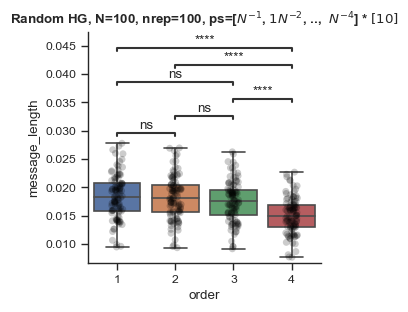

In [246]:
from statannotations.Annotator import Annotator

fix, ax = plt.subplots(figsize=(3, 3))

# palette = sb.color_palette("Set1", n_colors=4)

# box_params = {
#    'boxprops':{'facecolor':'none'},
#    'medianprops':{'color':'silver'},
#'whiskerprops':{'color':'blue'},
#'capprops':{'color':'yellow'}
# }

sb.boxplot(data=dff, x="order", y="message_length", ax=ax)  # , **box_params)

sb.stripplot(
    data=dff, x="order", y="message_length", ax=ax, color="black", dodge=True, alpha=0.2
)  # , legend=False)

sb.despine()
ax.set_title(
    rf"Random HG, N={N}, nrep={n_rep}, ps=[$N^{{-1}}$, $1 N^{{-2}}$, ..,  $N^{{-4}}$] * ${density_scales}$",
    weight="bold",
)


pairs = list(combinations(orders, 2))

annotator = Annotator(ax, pairs, data=dff, y="message_length", x="order")
annotator.configure(test="t-test_welch", text_format="star", loc="inside")
annotator.apply_and_annotate()

fig_name = f"message_length_RHG_N{N}_pwiring_{density_scales}_nreps_{n_rep}_boxplot"
plt.savefig(f"{out_dir}{fig_name}.png", dpi=250, bbox_inches="tight")